<a href="https://colab.research.google.com/github/jungihong10/LSTM/blob/main/lstm_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import csv

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data is already preprocessed

*   removed unused Co2 (avg, max, min) columns
*   check for empty values
*   check for odd values (too big/too small)



In [5]:
healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'


split the datafram into chunks of 200 rows each and then export each group of 200 rows as a single csv.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import random


def create_sequences_from_list(data_list, seq_length):
    sequences = []
    labels = []

    for data in data_list:
        unscaled_labels = data[:, -1]  # Store the original labels before scaling
        #scaled_data = scaler.fit_transform(data)
        #sequences.append(scaled_data[:seq_length, :-1])
        sequences.append(data[:seq_length, :-1])

        labels.append(unscaled_labels[0])  # Use the original unscaled label

    return np.array(sequences), np.array(labels)


def read_csv_files(folder_path, label):
    data_list = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        if len(df) >= 200:  # Filter out files with less than 200 readings
            df["label"] = label
            data_list.append(df.values[:200, :])  # Truncate to 200 rows and convert DataFrame to NumPy array
    return data_list


healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'

# Read and label the CSV files
healthy_data_list = read_csv_files(healthy_folder, 0)
diseased_data_list = read_csv_files(diseased_folder, 1)

all_data_list = healthy_data_list + diseased_data_list
random.shuffle(all_data_list)

# Scale the data
#scaler = MinMaxScaler()

# Create sequences
seq_length = 200
X, y = create_sequences_from_list(all_data_list, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
191/191 [==============================] - 14s 20ms/step - loss: 0.2404 - accuracy: 0.9170 - val_loss: 0.0190 - val_accuracy: 0.9987
Epoch 2/10
191/191 [==============================] - 4s 18ms/step - loss: 0.0318 - accuracy: 0.9936 - val_loss: 0.0099 - val_accuracy: 0.9987
Epoch 3/10
191/191 [==============================] - 5s 27ms/step - loss: 0.0485 - accuracy: 0.9900 - val_loss: 0.0135 - val_accuracy: 0.9987
Epoch 4/10
191/191 [==============================] - 4s 23ms/step - loss: 0.0154 - accuracy: 0.9972 - val_loss: 0.0040 - val_accuracy: 0.9987
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 8.4652e-04 - val_accuracy: 1.0000
Epoch 6/10
191/191 [==============================] - 4s 19ms/step - loss: 0.0491 - accuracy: 0.9847 - val_loss: 0.0195 - val_accuracy: 0.9987
Epoch 7/10
191/191 [==============================] - 3s 15ms/step - loss: 0.0137 - accuracy: 0.9977 - val_loss: 0.2980 - val_accuracy: 0

In [10]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


X shape: (7620, 200, 9)
y shape: (7620,)


In [11]:
print("X_train shape:", X)


X_train shape: [[[24.4 25.5 17.1 ... 14.1 19.2  6.2]
  [24.5 25.5 17.4 ... 17.5 20.1 11.1]
  [25.3 25.5 25.1 ... 14.9 19.2 12.3]
  ...
  [13.7 20.4 10.8 ... 11.  14.6  9.5]
  [14.5 20.3 10.6 ... 11.7 15.7  9.3]
  [12.5 20.3 10.6 ... 10.4 15.7  9.1]]

 [[22.1 23.7 21.1 ... 11.6 12.4 10.5]
  [27.1 28.5 24.4 ... 19.9 25.  12.7]
  [27.2 27.4 27.1 ... 22.8 22.8 22.8]
  ...
  [20.3 20.3 20.3 ... 19.4 19.4 19.4]
  [20.3 20.3 20.2 ... 19.4 19.4 19.4]
  [20.2 20.3 20.1 ... 19.4 19.4 19.4]]

 [[23.8 24.6 22.3 ... 16.1 18.7 14.2]
  [23.2 24.2 21.3 ... 14.7 16.8 13. ]
  [22.5 24.  20.5 ... 14.3 16.  13.2]
  ...
  [12.7 19.7 11.8 ... 11.3 13.5 10.9]
  [13.7 19.6 12.1 ... 11.6 13.7 10.9]
  [12.7 12.9 12.6 ... 11.8 11.9 11.6]]

 ...

 [[23.3 24.3 22.5 ... 16.1 17.5 14.9]
  [24.1 25.4 23.1 ... 16.8 17.  16.5]
  [24.9 27.3 23.5 ... 16.4 17.5 15.3]
  ...
  [19.4 20.3 11.9 ... 15.5 16.1 10.9]
  [24.  60.5 11.7 ... 21.6 59.2 10.6]
  [13.3 19.8 11.7 ... 10.1 15.9  0.9]]

 [[20.8 22.7 17.8 ... 14.2 17.5  8.

In [12]:
print("y_train shape:", y)


y_train shape: [0. 1. 0. ... 0. 0. 1.]


60/60 [==============================] - 1s 8ms/step


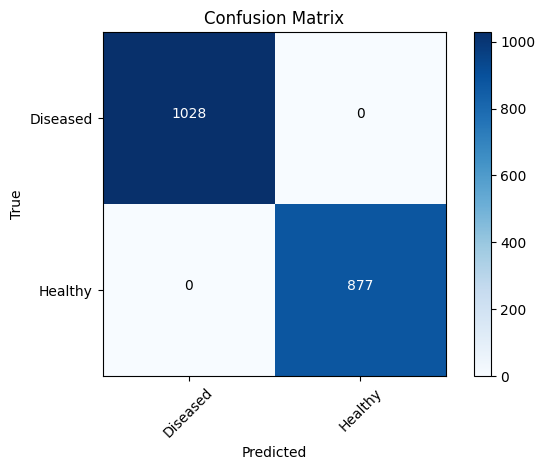

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Diseased', 'Healthy']

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")
plt.show()


In [14]:
from sklearn.metrics import precision_recall_fscore_support

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)


60/60 [==============================] - 1s 9ms/step
Precision: [1. 1.]
Recall: [1. 1.]
F1-score: [1. 1.]
Support: [1028  877]


Testing the model out using separate test cases.

In [15]:
def preprocess_single_file(file_path, seq_length):
    df = pd.read_csv(file_path)
    df["label"] = 0  # Add a dummy label column
    data = df.values[:seq_length, :]  # Truncate to seq_length rows if needed
    #scaled_data = scaler.transform(data)
    #X = np.array([scaled_data[:, :-1]])  # Create a 3D array with just one sample
    X = np.array([data[:, :-1]])  # Create a 3D array with just one sample

    return X

def status(x):
    if x > 0.5:
        print("Unhealthy")
    else:
        print("Healthy")
# Example usage:

sample_file_path = "/content/drive/MyDrive/d_data_test/preprocessed_d_605916.csv"
seq_length = 200

X_sample = preprocess_single_file(sample_file_path, seq_length)

# Predict on the sample file
y_sample_pred = model.predict(X_sample)
print(y_sample_pred[0])

# Print the result
status(y_sample_pred[0])





1/1 [==============================] - 0s 26ms/step
[0.99788517]
Unhealthy


In [16]:
# Example usage:

sample_file_path = "/content/drive/MyDrive/n_data_test/preprocessed_n_851866.csv"
seq_length = 200

X_sample = preprocess_single_file(sample_file_path, seq_length)

# Predict on the sample file
y_sample_pred = model.predict(X_sample)

# Print the result
print(y_sample_pred[0])

status(y_sample_pred[0])




1/1 [==============================] - 0s 27ms/step
[0.00039748]
Healthy


In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 50)           12000     
                                                                 
 dropout (Dropout)           (None, 200, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________
None
